In [27]:
import json
import pandas as pd
import numpy as np
import pprint as pp

from shapely.geometry import Polygon
from shapely.algorithms import polylabel # Function to find pole of inaccessibility to approximate the centroid of a polygon

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

## Preprocess

In [2]:
# Define constants

STORETOLERANCE = 5
CENTRALUS = dict(lat=39.0997,lon=-94.5786)

In [3]:
def get_centroids(dma_geo):
    """
    Returns the centroid(s) of a DMA region using the pole of inaccessibility algorithm (https://github.com/mapbox/polylabel) developed by MapBox. Function uses Shapely's 
    If the DMA has multiple polygons, return centroids for all polygons.
    
    Parameters:
        dma_geo (object) Object in format of GeoJSON and contains only one feature for one DMA
    
    Returns:
        centroids (list) Centroid objects are tuples in the format (lat,lon)
        
    Raises:
        Exception if geometry type is not of [Polygon, MultiPolygon]
    """
    
    geo_type = dma_geo.get('features')[0].get('geometry').get('type')
    geo_coords = dma_geo.get('features')[0].get('geometry').get('coordinates')
    
    centroids = []
    
    if geo_type == 'Polygon':
        centroid = polylabel.polylabel(Polygon(geo_coords[0]))
        centroids.append((centroid.y,centroid.x))
    elif geo_type == 'MultiPolygon':
        for polygon in geo_coords:
            centroid = polylabel.polylabel(Polygon(polygon[0]))
            centroids.append((centroid.y,centroid.x))
    else:
        raise Exception(f'Unsupported geometry type: {geo_type}')
        
    return centroids


def get_perf_color(val,store_cnt,store_tolerance=5):
    """
    Returns the performance color given the value. Returns the default color 'grey' if store_cnt == 0 or store_cnt < store_tolerance
    TODO: Add support for custom color scales as input to this function
    
    Parameters:
        val (number): input value
        store_cnt (number): store count of the DMA associated with the given value
        store_tolerance (number): defines minimum number of stores a DMA should have in order to display a color
    
    Returns:
    
    (str) Color in hex format
    """
    
    assert store_cnt >= 0, "store count must not be negative!"
    assert store_tolerance >= 1, "store tolerance must be at least 1!"
    
    # Define color scales here
    high_color = '#17800b'
    normal_color = '#2fff13'
    caution_color = '#ff8521'
    danger_color = '#ff0a2b'
    default_color = 'grey'
    
    high = 0.25
    normal = 0
    caution = -0.10
    
    # Only color sizable DMA's defined by store_tolerance
    if store_cnt > store_tolerance:
    
        if val > high:
            return high_color
        elif val > normal:
            return normal_color
        elif val > caution:
            return caution_color
        else:
            return danger_color
    else:
        return default_color

    
def get_dma_info(dma,perf_d,metric,store_tolerance):
    """
    Helper function to extract all pertinent information about the DMA in order to plot the DMA area effectively. Used in get_choropleths() and get_mapbox_choropleth_layers() 
    
    Parameters:
        dma (object): Dictionary object in GeoJson format
        perf_df (pd.DataFrame): Contains Performance metrics for associated dmas, must contain the column: dma_code, store_count to lookup performance metric for each dma from dmas_geo
        metric (str) :          Name of the column in perf_df to look up the color code on
        store_tolerance (number): Color only dmas with store greater than the store tolerance
    
    Returns:
        dma_info (object): Dictionary that contains all pertinent information: dma_code, dma_name, lat_ctr, lon_ctr, store_cnt,perf_color,perf_val
    
    """
    feature = dma.get('features')[0]

    # Extract DMA information
    dma_code = int(feature.get('id'))
    dma_name = feature.get('properties').get('dma1')

    # Get center of DMA, if GeoJSON object happens to not contain these coordinates, use get_centroids() function to retrieve a list of lat and lons for each Polygon in the DMA feature
    lat = feature.get('properties').get('latitude')
    lon = feature.get('properties').get('longitude')

    store_cnt = 0
    perf_val = 0

    # Lookup performance metric
    dma_s = perf_df.query(f'dma_code == {dma_code}').reset_index(drop=True)

    # No existing stores, color this DMA with the default color
    if dma_s.shape[0] == 0:
        perf_color = get_perf_color(0,0,store_tolerance) # Get the default color returned from get_perf_color()
    else:
        perf_val = dma_s.at[0,metric]
        store_cnt = dma_s.at[0,'store_count']
        perf_color = get_perf_color(perf_val,store_cnt,store_tolerance)

    return dict(dma_code=dma_code,
                dma_name=dma_name,
                lat_ctr=lat,
                lon_ctr=lon,
                store_cnt=store_cnt,
                perf_color=perf_color,
                perf_val=perf_val)


In [4]:
# Assumes input source is GeoJson format
with open("nielsengeo.json") as geofile:
    source_geo = json.load(geofile)

dmas_geo = [dict(type='FeatureCollection',features=[feat]) for feat in source_geo.get('features')]

# Load Performance metrics for each dma
perf_df = pd.read_csv('performance_by_dma.csv')
pp.pprint(perf_df.columns.to_list())

['dma_code', 'dma', 'sales_growth', 'trans_growth', 'store_count']


In [5]:
pp.pprint(dmas_geo[0],width=100,depth=4)

{'features': [{'geometry': {'coordinates': [...], 'type': 'Polygon'},
               'id': 662,
               'properties': {'dma': 662,
                              'dma1': 'Abilene-Sweetwater, TX',
                              'latitude': 32.404348,
                              'longitude': -99.8293625,
                              'name': 'dma:'},
               'type': 'Feature'}],
 'type': 'FeatureCollection'}


## Pure Plotly Version

In [33]:
def get_choropleths(dmas_geo,perf_df,metric,store_tolerance):
    """
    Given a list of DMA GeoJson objects, return a list of plotly.S to create Plotly scatter traces and DMA centers to plot.
    
    Parameters:
        dmas_geo (sequence):    Contains geojson objects. Each object only contains one dma.
        perf_df (pd.DataFrame): Contains Performance metrics for associated dmas, must contain the column: dma_code, store_count to lookup performance metric for each dma from dmas_geo
        metric (str) :          Name of the column in perf_df to look up the color code on
        store_tolerance (number): Color only dmas with store greater than the store tolerance

    Returns:
        data (list): contains Scatter trace object definitions to plot the areas and centroids of the map
    
    Raises:
        Exception if geometry type is not of [Polygon, MultiPolygon]
    """
    
    data = []
    lat_centers = []
    lon_centers = []
    center_tooltips = []
    
    for dma in dmas_geo:
        
        dma_info = get_dma_info(dma,perf_df,metric,store_tolerance)
        
        # Extract all polygons in the DMA
        geo_type = dma.get('features')[0].get('geometry').get('type')
        geo_coords = dma.get('features')[0].get('geometry').get('coordinates')
        dma_traces = []
        
        if geo_type == 'Polygon':
            x_coords, y_coords = zip(*geo_coords[0])
            
            data.append(create_area(x_coords,
                                    y_coords,
                                    dma_info.get('perf_color')))
        elif geo_type == 'MultiPolygon':
            
            for polygon in geo_coords:
                x_coords, y_coords = zip(*polygon[0])
            
                dma_traces.append(create_area(x_coords,
                                              y_coords,
                                              dma_info.get('perf_color')))
        else:
            raise Exception(f'Unsupported geometry type: {geo_type}')
        
        data.extend(dma_traces)
                                                                                                              
        # Add markers on centroid for this DMA to enable hoverboxes within each DMA region
        lat_centers.append(dma_info.get('lat_ctr'))
        lon_centers.append(dma_info.get('lon_ctr'))
        center_tooltips.append('DMA: {:s}<br>Store Count: {:d}<br>Metric: {:.1f}%'.format(dma_info.get('dma_name') ,
                                                                                          dma_info.get('store_cnt'),
                                                                                          dma_info.get('perf_val') * 100))
    
    # Define the centers object for plotly to plot all this hidden markers to enable tooltips
    centers = dict(type='scatter',
                   mode='markers',
                   showlegend=False,
                   marker=dict(size=5,opacity=0),
                   text=center_tooltips,
                   x=lon_centers,
                   y=lat_centers,
                   hoverinfo='text',
                   hoverlabel=dict(bgcolor='white')
                  )
    
    data.append(centers)
        
    return data

def create_area(x_coords,y_coords,perf_color):
    """
    Helper function to return an object that defines a Scatter trace for plotly. This Scatter trace creates a filled area defined by the x and y coordinates
    
    Parameters:
        x_coords (list): List of x coordinates
        y_coords (list): List of y coordinates
        perf_color (str): Color to fill the area
    
    Returns:
        area (object) plotly Scatter definition
    
    """
    return dict(type='scatter',
                showlegend = False,
                mode='lines',
                line=dict(color='black',width=1),
                x = x_coords,
                y = y_coords,
                fill='toself',
                fillcolor=perf_color,
                hoverinfo='none')

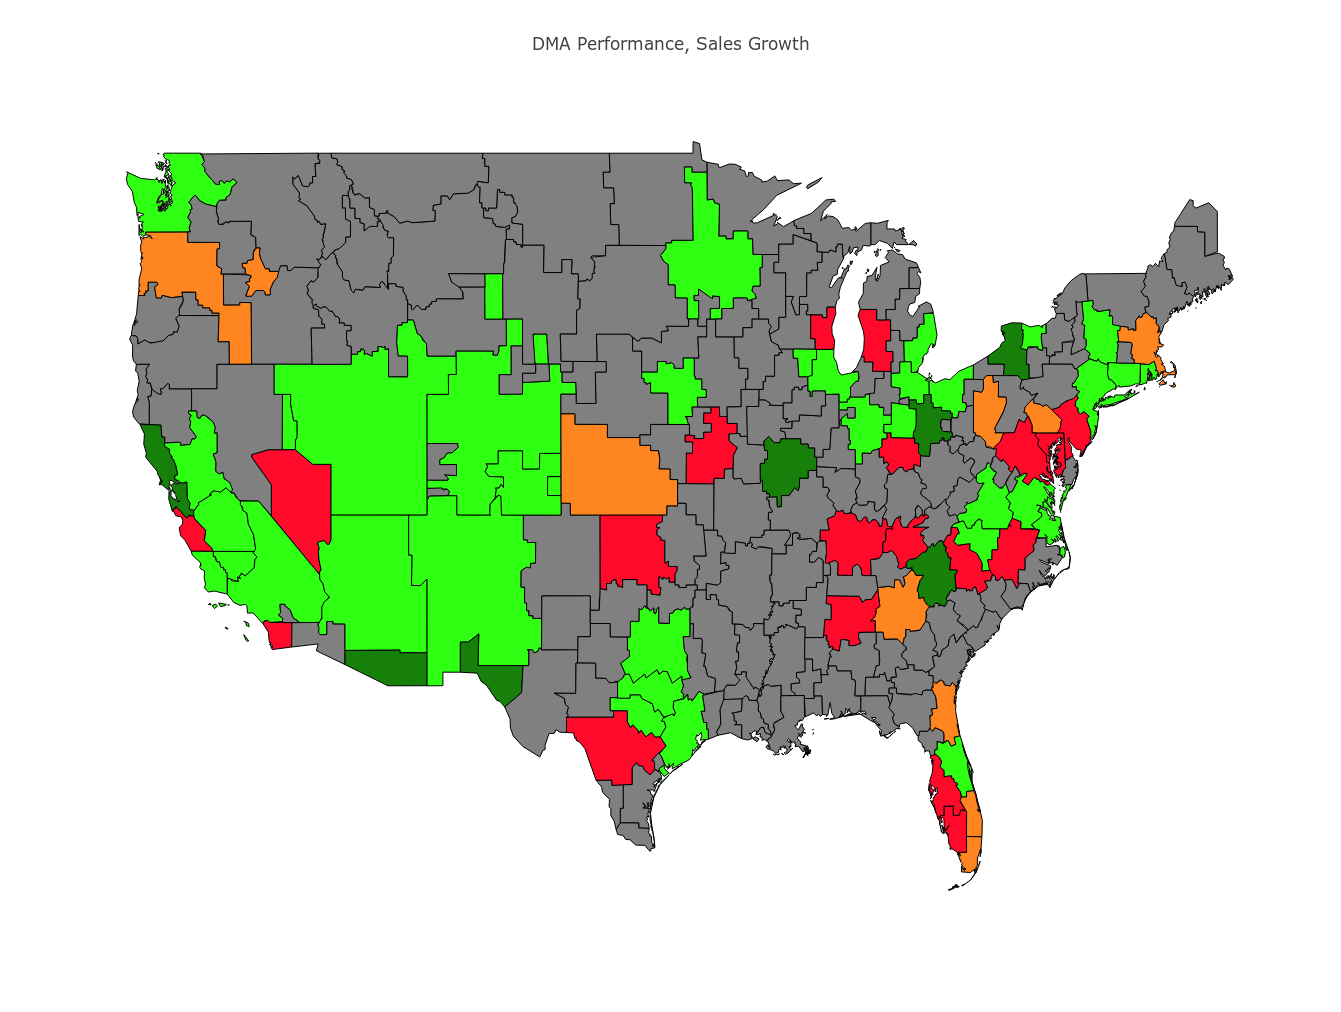

In [34]:
data = get_choropleths(dmas_geo,perf_df,'sales_growth',STORETOLERANCE)

axis = dict(showgrid=False,showticklabels=False)

layout = dict(title='DMA Performance, Sales Growth',
              height=1000,
              width = 1500,
              hovermode='closest',
              xaxis=axis,
              yaxis=axis,
              plot_bgcolor='white')

fig = dict(data=data,layout=layout)
iplot(fig)

## MapBox Version

In [32]:
def get_mapbox_choropleth_layers(dmas_geo,perf_df,metric,store_tolerance):
    """
    Given a list of DMA GeoJson objects, return a list of layers and DMA centers to plot using the MapBox layout in plotly.
    
    Parameters:
        dmas_geo (sequence):      Contains geojson objects. Each object only contains one dma.
        perf_df (pd.DataFrame):   Contains Performance metrics for associated dmas, must contain the column: dma_code, store_count to lookup performance metric for each dma from dmas_geo
        metric (str) :            Name of the column in perf_df to look up the color code on
        store_tolerance (number): Color only dmas with store greater than the store tolerance

    Returns:
        layers, centers (tuple) layers contains a list of layer objects, centers contains a list of scattermapbox marker objects with tooltips
    """

    layers = []
    lat_centers = []
    lon_centers = []
    center_tooltips = []
    
    # To improve performance, define GeoJson objects for each color returned by the function get_perf_color() and create only one layer for each unique color 
    # instead of one layer for each individual DMA (200+ DMAs)
    
    geos = dict()
    
    for dma in dmas_geo:

        dma_info = get_dma_info(dma,perf_df,metric,store_tolerance)
        
        if geos.get(dma_info.get('perf_color')) is None:
            # Color doesn't exist yet, create a new key based on the perf color
            geos[dma_info.get('perf_color')] = [dma.get('features')[0]]
        else:
            # Add the geometry to a running list of other geometries
            geos.get(dma_info.get('perf_color')).append(dma.get('features')[0])
        
        # Add markers on centroid for this DMA to enable hoverboxes within each DMA region
        lat_centers.append(dma_info.get('lat_ctr'))
        lon_centers.append(dma_info.get('lon_ctr'))
        center_tooltips.append('DMA: {:s}<br>Store Count: {:d}<br>Metric: {:.1f}%'.format(dma_info.get('dma_name') ,
                                                                                          dma_info.get('store_cnt'),
                                                                                          dma_info.get('perf_val') * 100))
    # Build layers
    for color in geos.keys():
        
        # Create GeoJson object
        source = dict(type='FeatureCollection',
                      features=geos.get(color))
        
        layer = dict(name = color,
                     sourcetype = 'geojson',
                     source = source,
                     type = 'fill',
                     color = color,
                     fill = dict(outlinecolor = 'black'),
                     opacity = 0.85,
                     below='water'
                )
        layers.append(layer)
    
    # Build markers to enable hover text within each DMA
    centers = dict (type='scattermapbox',
                    mode='markers',
                    showlegend=False,
                    text=center_tooltips,
                    marker=dict(size=5,opacity=0),
                    lon=lon_centers,
                    lat=lat_centers,
                    hoverinfo='text'
    )

    return layers, centers

In [29]:
# Load token
with open('mapbox_token','r') as fin:
    mapbox_token = fin.readline()

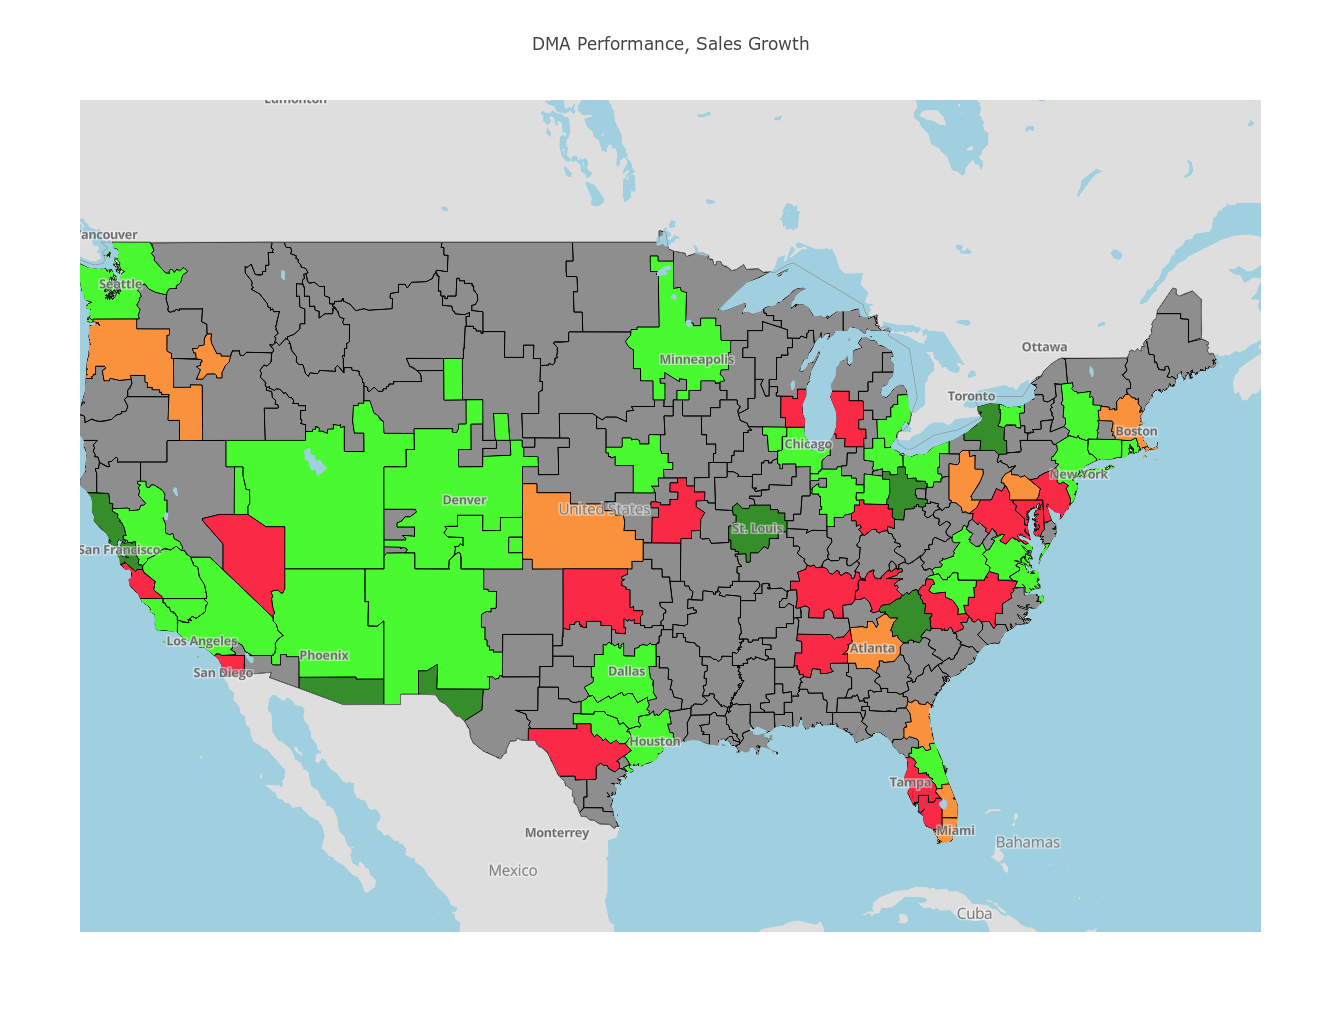

In [31]:
layers, centers = get_mapbox_choropleth_layers(dmas_geo,perf_df,'sales_growth',STORETOLERANCE)

# Create the Layout using MapBox as the source of the map coordinates
layout = go.Layout(
    title='DMA Performance, Sales Growth',
    height=1000,
    width = 1500,
    hovermode='closest',
    mapbox=dict(
        layers=layers,
        accesstoken=mapbox_token,
        center=CENTRALUS,
        pitch=0,
        zoom=3.8
    )
)

fig = dict(data=[centers],layout=layout)
iplot(fig)